# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Modify `wrangle` function to engineer a new feature. Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_rf`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` and `n_estimators` to reduce overfitting.
- **Task 9:** Generate list of predictions for `X_test`.
- **Task 9 `stretch goal`:** Create `submissions.csv` file and upload on kaggle competition site.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

# I. Wrangle Data

In [5]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'


import sys
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [6]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)


    #function to engineer a 'pump_age' feature
    df['pump_age'] = 2023 - df['construction_year']

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [8]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv',
             DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [9]:
X = df.drop(columns='status_group')
y = df['status_group']

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47519, 30), (11880, 30), (47519,), (11880,))

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [12]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [13]:
ordinal = OrdinalEncoder()
mean = SimpleImputer()
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rf = make_pipeline(ordinal, mean, rf)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
hand pump                      2
other                          3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
hand pump             2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [14]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9952440076600939
Validation Accuracy Score: 0.8037878787878788


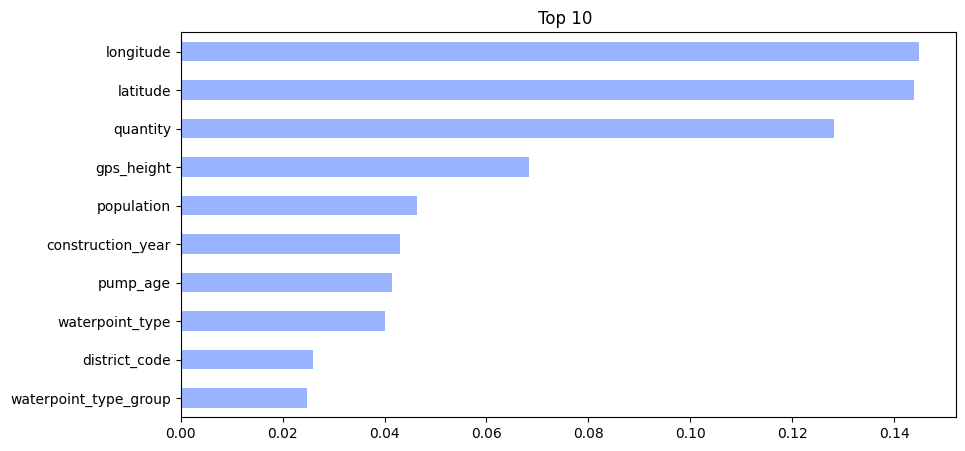

In [21]:
#lets look at what features had the most sway

encoder = model_rf.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

%matplotlib inline

import matplotlib.pyplot as plt

hmm = model_rf.named_steps['randomforestclassifier']
importances = pd.Series(hmm.feature_importances_, encoded.columns)

n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} ')
importances.sort_values()[-n:].plot.barh(color='#99b3ff')
plt.show()

# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

In [ ]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6
""" rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__max_depth': [10, 50, 100, None],
    'randomforestclassifier__max_features': [2, 3],
    'randomforestclassifier__min_samples_leaf': [2, 3, 4, 5],
    'randomforestclassifier__min_samples_split': [8, 10, 12],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400]
}

rf_grid = RandomizedSearchCV(
    estimator=model_rf, param_distributions=param_grid, n_iter=100, cv=3)
rf_grid.fit(X_train, y_train)

training_acc = rf_grid.score(X_train, y_train)
val_acc = rf_grid.score(X_val, y_val) """

In [15]:
train_acc = []
val_acc = []
#estimates = np.arange(200,250, 10)
#entropy < gini
#depths = np.arange(10, 100, 10)
#splits = [2,3,4,5]
#samples = [1,2,3,4,5]
forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(max_samples= 1.0, random_state=42, n_jobs=-1, n_estimators=232, max_depth=70, min_samples_split=4, min_samples_leaf=2)
)

forest_model.fit(X_train, y_train)
train_acc.append(forest_model.score(X_train, y_train))
val_acc.append(forest_model.score(X_val, y_val))

In [16]:
print(train_acc)
print(val_acc)

[0.9207264462635998]
[0.8111952861952862]


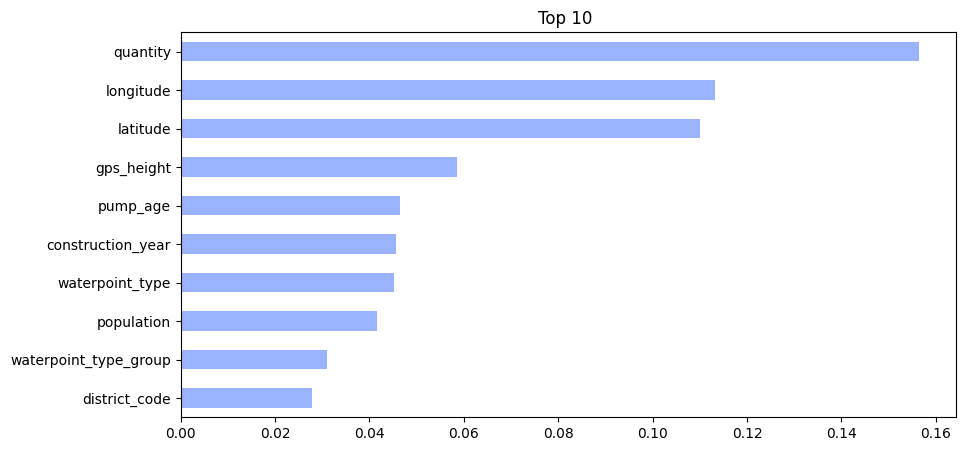

In [22]:
#lets look at what features had the most sway

encoder = forest_model.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

%matplotlib inline

import matplotlib.pyplot as plt

hmm = forest_model.named_steps['randomforestclassifier']
importances = pd.Series(hmm.feature_importances_, encoded.columns)

n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} ')
importances.sort_values()[-n:].plot.barh(color='#99b3ff')
plt.show()

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [17]:
y_pred = forest_model.predict(X_test)
print(len(X_test))
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

14358


**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [18]:
submission = pd.DataFrame(data=y_pred, index=X_test.index, columns=['status_group'])
submission.to_csv('submission')